In [31]:
import torch
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
import os
import gc
import json
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision import transforms
from IPython.display import clear_output
import pandas as pd
import wandb
import random
import copy
import joblib
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, CLIPProcessor, CLIPModel, AutoImageProcessor, AutoModel, AutoModelForCausalLM, AutoProcessor, VisionTextDualEncoderModel, VisionTextDualEncoderProcessor
from transformers import ViltProcessor, ViltModel

In [32]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device1 = "cuda:1" if torch.cuda.device_count() > 1 else "cpu"

print(f"Thiết bị 0: {device}")
print(f"Thiết bị 1: {device1}")


Thiết bị 0: cuda:0
Thiết bị 1: cpu


In [33]:
# vit5 -------------------------------------------------------------------
vit5_model = AutoModelForSeq2SeqLM.from_pretrained("VietAI/vit5-base")
vit5_processor = AutoTokenizer.from_pretrained("VietAI/vit5-base")
#clip ---------------------------------------------------------------------
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [34]:
# Đường dẫn đến thư mục chứa ảnh
image_train_dir = '/kaggle/input/dsc-dataset/train-images/train-images' 
image_test_dir = '/kaggle/input/data-private/private-test-images/test-images'

# Lấy danh sách các tệp ảnh .jpg
image_train_paths = [os.path.join(image_train_dir, file) for file in os.listdir(image_train_dir) if file.endswith('.jpg')]
image_test_paths = [os.path.join(image_test_dir, file) for file in os.listdir(image_test_dir) if file.endswith('.jpg')]

# Đọc dữ liệu từ file JSON
with open('/kaggle/input/data-demoji-remove-hashtag-specialword/processed_train_demoji_remove_hashtag_specialWord.json', 'r', encoding='utf-8') as f:
    data_train = json.load(f)

with open('/kaggle/input/data-private/processed_private_demoji_remove_hashtag_url_v7.json', 'r', encoding='utf-8') as f:
    data_test = json.load(f)
    

combined_data_train = []
combined_data_test = []

label_mapping = {
    "not-sarcasm": 0,
    "text-sarcasm": 1,
    "image-sarcasm": 2,
    "multi-sarcasm": 3,
}

# Khởi tạo biến id để đếm số lượng mục
train_id = 0
test_id = 0

# Duyệt qua từng mục trong dữ liệu JSON để tạo combined_data_train
for key, value in data_train.items():
    image_name = value["image"]
    image_path = os.path.join(image_train_dir, image_name)  # Tạo đường dẫn tuyệt đối cho từng hình ảnh
    
    # Kiểm tra xem ảnh có trong danh sách hay không
    if image_path in image_train_paths:
        label = value.get("label")  # Lấy giá trị label
        if label is not None and label in label_mapping:  # Kiểm tra giá trị label
            combined_data_train.append({
                'id': train_id,  # Thêm id theo thứ tự
                'image': image_path,  # Lưu đường dẫn tuyệt đối
                'caption': value["caption"],
                'label': label_mapping[label],  # Lưu label từ label_mapping\
#                 'text_image': value["text_image"]
            })
            train_id += 1  # Tăng id sau mỗi lần thêm

# Duyệt qua từng mục trong dữ liệu JSON để tạo combined_data_test
for key, value in data_test.items():
    image_name = value["image"]
    image_path = os.path.join(image_test_dir, image_name)  # Tạo đường dẫn tuyệt đối cho từng hình ảnh

    # Kiểm tra xem ảnh có trong danh sách hay không
    if image_path in image_test_paths:
        combined_data_test.append({
            'id': test_id,  # Thêm id theo thứ tự
            'image': image_path,  # Lưu đường dẫn tuyệt đối
            'caption': value["caption"],
            'label': value["label"],  # Lưu label từ label_mapping
#             'text_image': value["text_image"]
        })
        test_id += 1  # Tăng id sau mỗi lần thêm

# In ra kết quả
# print(combined_data_train)
# print(combined_data_test)

# Tách caption và label từ combined_data_train
texts_train = [item['caption'] for item in combined_data_train]
labels_train = [item['label'] for item in combined_data_train]
id_train = [item['id'] for item in combined_data_train]
images_train = [item['image'] for item in combined_data_train]
# text_images_train = [item['text_image'] for item in combined_data_train]
texts_test = [item['caption'] for item in combined_data_test]
labels_test = [item['label'] for item in combined_data_test]
id_test = [item['id'] for item in combined_data_test]
images_test = [item['image'] for item in combined_data_test]
# text_image_test = [item['text_image'] for item in combined_data_test]


### extract_clip_features

#  extract_vit5_features

In [35]:
def extract_vit5_features(texts, batch_size=16):
    all_features = []
    
    # Chuyển mô hình ViT5 sang GPU
    vit5_model.to(device)
    
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i + batch_size]
        
        # Chuyển đổi văn bản thành tensor và đưa vào GPU
        inputs = vit5_processor(batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)
        
        with torch.no_grad():
            # Gọi mô hình mà không cần decoder
            outputs = vit5_model.encoder(**inputs)  # Sử dụng encoder để lấy hidden states
            hidden_states = outputs.last_hidden_state  # (batch_size, seq_len, hidden_dim)
        
        # Tính trung bình theo trục seq_len (trục 1)
        mean_features = hidden_states.mean(dim=1)  # (batch_size, hidden_dim)
        
        # Chuyển về CPU và numpy để lưu trữ
        all_features.append(mean_features.cpu().numpy())
        
        # Giải phóng bộ nhớ
        del inputs, outputs, hidden_states, mean_features
        torch.cuda.empty_cache()  # Dọn dẹp bộ nhớ GPU nếu cần

    return np.concatenate(all_features, axis=0)


# Clip

In [36]:
from tqdm import tqdm

def extract_clip_features(image_paths, texts, batch_size=14):
    all_image_features = []
    all_text_features = []
    
    # Chuyển mô hình CLIP sang GPU
    clip_model.to(device)
    
    # Sử dụng tqdm để hiển thị tiến độ của vòng lặp
    for i in tqdm(range(0, len(image_paths), batch_size), desc="Processing batches"):
        batch_paths = image_paths[i:i + batch_size]
        batch_texts = texts[i:i + batch_size]
        
        # Mở hình ảnh và chuyển sang định dạng RGB
        images = [Image.open(image_path).convert("RGB") for image_path in batch_paths]
        
        # Chuyển đổi hình ảnh và văn bản thành tensor
        inputs = clip_processor(images=images, text=batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=77).to(device)
        
        with torch.no_grad():
            # Lấy đặc trưng hình ảnh và văn bản
            image_features = clip_model.get_image_features(pixel_values=inputs['pixel_values'])
            text_features = clip_model.get_text_features(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        
        all_image_features.append(image_features.cpu().numpy())
        all_text_features.append(text_features.cpu().numpy())
        
        # Giải phóng bộ nhớ
        del images, inputs, image_features, text_features
        gc.collect()
        torch.cuda.empty_cache()
    
    # Kết hợp tất cả các đặc trưng hình ảnh và văn bản
    all_image_features = np.concatenate(all_image_features, axis=0)
    all_text_features = np.concatenate(all_text_features, axis=0)
    
    return all_image_features, all_text_features


In [37]:
# train_image_features, train_text_features = extract_clip_features(images_train, texts_train)
# np.save('/kaggle/working/train_text_clip_features.npy',train_text_features)
# np.save('/kaggle/working/train_image_clip_features.npy',train_image_features)

In [38]:
# val_image_features, val_text_features = extract_clip_features(images_val, texts_val)
# np.save('/kaggle/working/val_aug_text_1_features.npy',val_text_features)
# np.save('/kaggle/working/val_aug_image_1_features.npy',val_image_features)

In [39]:
# test_image_features, test_text_features = extract_clip_features(images_test, texts_test)
# np.save('/kaggle/working/test_text_clip_features.npy',test_text_features)
# np.save('/kaggle/working/test_image_clip_features.npy',test_image_features)

### save train val --image-- clip_model

In [40]:
# train_image_features = extract_clip_features(images_train)
# np.save('/kaggle/working/train_aug_image_features.npy', train_image_features)

In [41]:
# val_image_features = extract_clip_features(images_val)
# np.save('/kaggle/working/val_aug_image_features.npy', val_image_features)

### save train val --text-- vit5_model

In [42]:
# train_text_vit5_text_sarcasm_features = extract_vit5_features(texts_train)
# np.save('/kaggle/working/train_text_vit5_text_sarcasm_features.npy', train_text_vit5_text_sarcasm_features)

In [43]:
# test_text_vit5_text_sarcasm_features = extract_vit5_features(texts_test)
# np.save('/kaggle/working/test_text_vit5_text_sarcasm_features.npy', test_text_vit5_text_sarcasm_features)

### save train val --text + orc-- vit5_model

In [44]:
# train_ocr_features = extract_vit5_features(text_image_train)
# np.save('/kaggle/working/train_aug_ocr_features.npy', train_ocr_features)

In [45]:
# val_ocr_features = extract_vit5_features(text_image_val)
# np.save('/kaggle/working/val_aug_ocr_features.npy', val_ocr_features)

In [48]:
train_text_clip_features = np.load('/kaggle/input/new-features-clip-vit5/train_text_clip_features (1).npy')
train_image_clip_features = np.load('/kaggle/input/new-features-clip-vit5/train_image_clip_features (1).npy')

test_text_clip_features = np.load('/kaggle/input/feature-vilt-clip-vit5-private-test-v1/test_text_clip_features.npy')
test_image_clip_features = np.load('/kaggle/input/feature-vilt-clip-vit5-private-test-v1/test_image_clip_features.npy')

train_text_vit5_features = np.load('/kaggle/input/feature-vilt-clip-vit5-private-test-v1/train_text_vit5_features.npy')
test_text_vit5_features = np.load('/kaggle/input/feature-vilt-clip-vit5-private-test-v1/test_text_vit5_features.npy')


In [49]:
print(train_image_clip_features.shape, train_text_clip_features.shape)
print(test_image_clip_features.shape, test_text_clip_features.shape)
print(train_text_vit5_features.shape)


(10805, 768) (10805, 768)
(1504, 768) (1504, 768)
(10805, 768)


In [50]:
X_train = np.concatenate((
                        train_text_vit5_features, 
                        train_text_clip_features, 
                        train_image_clip_features, 
                          ), axis=1)

In [51]:
df_train = pd.DataFrame(X_train)
df_target = pd.DataFrame(labels_train, columns=['label'])

In [52]:
df = pd.concat([df_train, df_target], axis=1)
print(len(df))

10805


In [53]:
features = df_train.columns

In [54]:
# Tạo 4 DataFrame dựa trên giá trị của cột 'label'
df_label_0 = df[df['label'] == 0]
df_label_1 = df[df['label'] == 1]
df_label_2 = df[df['label'] == 2]
df_label_3 = df[df['label'] == 3]

# Hiển thị kết quả
print("DataFrame cho label 0:")
print(len(df_label_0))
print("\nDataFrame cho label 1:")
print(len(df_label_1))
print("\nDataFrame cho label 2:")
print(len(df_label_2))
print("\nDataFrame cho label 3:")
print(len(df_label_3))


DataFrame cho label 0:
6062

DataFrame cho label 1:
77

DataFrame cho label 2:
442

DataFrame cho label 3:
4224


In [55]:
X_test = np.concatenate((
                         test_text_vit5_features, 
                         test_text_clip_features,
                         test_image_clip_features, 
                         ), axis=1)

In [56]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek

# Giả sử X và y là dữ liệu và nhãn của bạn
X_train, X_val, y_train, y_val = train_test_split(df[features], df['label'], test_size=0.2, random_state=42)

# Khởi tạo SMOTE
smote = SMOTE(sampling_strategy='auto',random_state=42, k_neighbors=5)

# Tăng cường dữ liệu lớp thiểu số
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Kiểm tra kết quả
print("Kích thước X_train trước SMOTE:", X_train.shape)
print("Kích thước X_train sau SMOTE:", X_train_resampled.shape)
print("Kích thước y_train sau SMOTE:", y_train_resampled.shape)


Kích thước X_train trước SMOTE: (8644, 2304)
Kích thước X_train sau SMOTE: (19408, 2304)
Kích thước y_train sau SMOTE: (19408,)


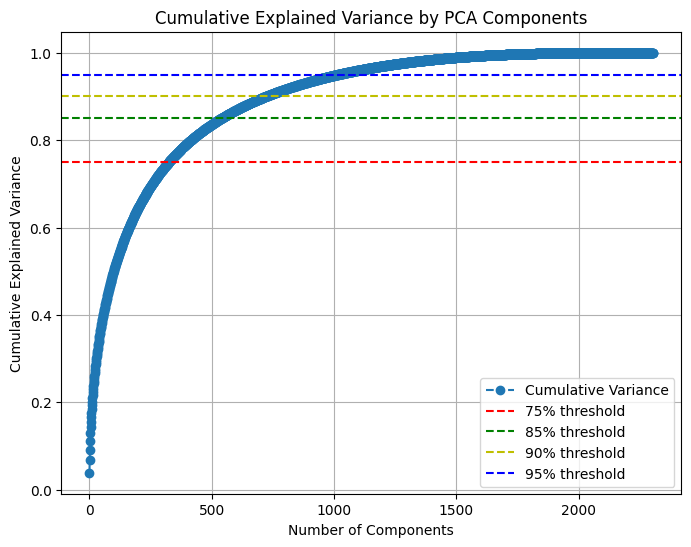

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Giả sử X_train là dữ liệu đặc trưng
# X_train = <dữ liệu đặc trưng của bạn>

# Tiến hành PCA
pca = PCA()
pca.fit(X_train)

# Lấy phương sai giải thích (explained variance)
explained_variance = pca.explained_variance_ratio_

# Tính phương sai tích lũy
cumulative_variance = np.cumsum(explained_variance)

# Vẽ biểu đồ cumulative variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)

# Đánh dấu điểm có tổng phương sai tích lũy khoảng 90% hoặc 95%
plt.axhline(y=0.75, color='r', linestyle='--')
plt.axhline(y=0.85, color='g', linestyle='--')
plt.axhline(y=0.90, color='y', linestyle='--')
plt.axhline(y=0.95, color='b', linestyle='--')
plt.legend(['Cumulative Variance','75% threshold', '85% threshold' ,'90% threshold', '95% threshold'])

# Hiển thị biểu đồ
plt.show()


# SVM

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Bước 1: Chuẩn hóa các đặc trưng
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Bước 2: Áp dụng PCA
pca = PCA(n_components=0.85)  # Giữ lại 80% phương sai
X_train_pca = pca.fit_transform(X_train_scaled)

# Kiểm tra số lượng thành phần chính
print(f"Number of principal components: {pca.n_components_}")

# Nếu bạn có tập validation, hãy chuẩn hóa và biến đổi chúng cũng như vậy
X_val_scaled = scaler.transform(X_val)
X_val_pca = pca.transform(X_val_scaled)

# Kiểm tra tỷ lệ phương sai được giữ lại
print(f"Explained variance ratio: {np.sum(pca.explained_variance_ratio_):.2f}")

# Bước 3: Thiết lập mô hình SVM với các tham số cụ thể
svm_model = SVC(C=1, kernel='rbf', gamma='scale')

# Bước 4: Huấn luyện mô hình trên tập dữ liệu huấn luyện
# svm_model.fit(X_train_pca, y_train_resampled)
svm_model.fit(X_train_pca, y_train)

# Bước 5: Đánh giá mô hình trên tập validation
val_predictions = svm_model.predict(X_val_pca)

accuracy = accuracy_score(y_val, val_predictions)
report = classification_report(
    y_val, val_predictions,
    target_names=["not-sarcasm", "text-sarcasm", "image-sarcasm", "multi-sarcasm"]
)

# Tính toán và hiển thị ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_val, val_predictions)
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix,
    display_labels=["not-sarcasm", "text-sarcasm", "image-sarcasm", "multi-sarcasm"]
)

# Vẽ ma trận nhầm lẫn
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# Bước 6: In kết quả
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(report)


# SVM + SMOTE

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Bước 1: Chuẩn hóa các đặc trưng
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)

# Bước 2: Áp dụng PCA
pca = PCA(n_components=0.85)  # Giữ lại 80% phương sai
X_train_pca = pca.fit_transform(X_train_scaled)

# Kiểm tra số lượng thành phần chính
print(f"Number of principal components: {pca.n_components_}")

# Nếu bạn có tập validation, hãy chuẩn hóa và biến đổi chúng cũng như vậy
X_val_scaled = scaler.transform(X_val)
X_val_pca = pca.transform(X_val_scaled)

# Kiểm tra tỷ lệ phương sai được giữ lại
print(f"Explained variance ratio: {np.sum(pca.explained_variance_ratio_):.2f}")

# Bước 3: Thiết lập mô hình SVM với các tham số cụ thể
svm_model = SVC(C=1, kernel='rbf', gamma='scale')

# Bước 4: Huấn luyện mô hình trên tập dữ liệu huấn luyện
svm_model.fit(X_train_pca, y_train_resampled)

# Bước 5: Đánh giá mô hình trên tập validation
val_predictions = svm_model.predict(X_val_pca)

accuracy = accuracy_score(y_val, val_predictions)
report = classification_report(
    y_val, val_predictions,
    target_names=["not-sarcasm", "text-sarcasm", "image-sarcasm", "multi-sarcasm"]
)

# Tính toán và hiển thị ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_val, val_predictions)
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix,
    display_labels=["not-sarcasm", "text-sarcasm", "image-sarcasm", "multi-sarcasm"]
)

# Vẽ ma trận nhầm lẫn
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# Bước 6: In kết quả
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(report)


# Ensemble + SMOTE

Explained variance ratio: 0.85


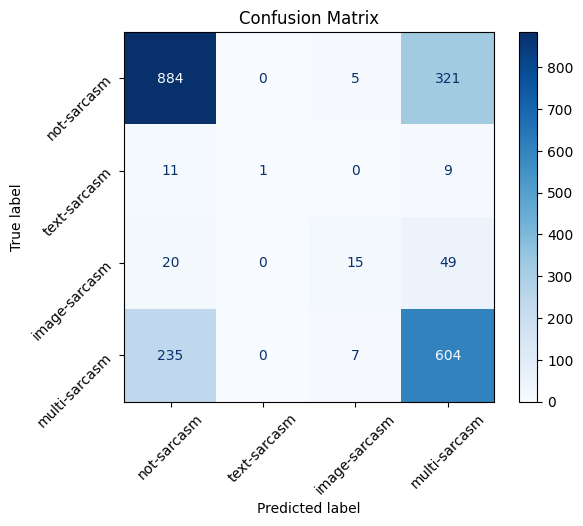

Validation Accuracy: 69.60%
Classification Report:
               precision    recall  f1-score   support

  not-sarcasm       0.77      0.73      0.75      1210
 text-sarcasm       1.00      0.05      0.09        21
image-sarcasm       0.56      0.18      0.27        84
multi-sarcasm       0.61      0.71      0.66       846

     accuracy                           0.70      2161
    macro avg       0.73      0.42      0.44      2161
 weighted avg       0.70      0.70      0.69      2161



In [61]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Bước 1: Chuẩn hóa các đặc trưng
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)

# Bước 2: Áp dụng PCA
pca = PCA(n_components=0.85)  # Giữ lại 55% phương sai
X_train_pca = pca.fit_transform(X_train_scaled)

# Kiểm tra tỷ lệ phương sai được giữ lại
print(f"Explained variance ratio: {np.sum(pca.explained_variance_ratio_):.2f}")

# Chuẩn hóa và biến đổi tập validation
X_val_scaled = scaler.transform(X_val)
X_val_pca = pca.transform(X_val_scaled)

# Bước 3: Khởi tạo các mô hình thành phần
# rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
# xgb_model = XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
# svc_model = SVC(C=1, kernel='rbf', gamma='scale', probability=True)  # Đặt `probability=True` để hỗ trợ voting='soft'
# Khởi tạo các mô hình với tham số mặc định
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
svc_model = SVC(C=1, kernel='rbf', gamma='scale', probability=True)  # `probability=True` để hỗ trợ voting='soft'

# Bước 4: Thiết lập VotingClassifier
voting_model = VotingClassifier(
    estimators=[('rf', rf_model), ('xgb', xgb_model), ('svc', svc_model)],
    voting='soft'  # 'soft' dựa trên xác suất, 'hard' dựa trên nhãn đa số
)

# Huấn luyện mô hình VotingClassifier
voting_model.fit(X_train_pca, y_train_resampled)

# Bước 5: Đánh giá mô hình trên tập validation
val_predictions = voting_model.predict(X_val_pca)

# Độ chính xác và báo cáo phân loại
accuracy = accuracy_score(y_val, val_predictions)
report = classification_report(
    y_val, val_predictions,
    target_names=["not-sarcasm", "text-sarcasm", "image-sarcasm", "multi-sarcasm"]
)

# Tính toán và hiển thị ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_val, val_predictions)
disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix,
    display_labels=["not-sarcasm", "text-sarcasm", "image-sarcasm", "multi-sarcasm"]
)

# Vẽ ma trận nhầm lẫn
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# Bước 6: In kết quả
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(report)


In [62]:
import json
import numpy as np
import zipfile

import os
from collections import Counter

# Step 1: Standardize the test set
X_test_scaled = scaler.transform(X_test)

# Step 2: Apply PCA to the test set
X_test_pca = pca.transform(X_test_scaled)

# Step 3: Make predictions on the test set using the PCA-transformed test data
# test_predictions = svm_model.predict(X_test_pca)
test_predictions = voting_model.predict(X_test_pca)

# Step 4: Create an inverse mapping to convert numerical predictions back to text labels
inverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Convert numerical predictions to text labels
text_predictions = [inverse_label_mapping[int(pred)] for pred in test_predictions]

# Step 5: Count the occurrences of each predicted class
class_counts = Counter(text_predictions)
print("Class prediction counts:", class_counts)

# Step 6: Prepare results in the required JSON format
results = {
    "results": {},
    "phase": "test"  # Update phase if needed
}

# Assume you have an array `id_test` containing IDs corresponding to the test data
for sample_id, label in zip(id_test, text_predictions):
    results["results"][str(sample_id)] = label

# Step 7: Save the results to a JSON file
output_json_path = '/kaggle/working/results.json'
with open(output_json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

# Step 8: Zip the JSON file
with zipfile.ZipFile('TA_result_22.zip', 'w') as zipf:
    zipf.write(output_json_path, arcname='results.json')

# Step 9: Print confirmation
print("Results saved to results.json and zipped as results.zip.")


Class prediction counts: Counter({'multi-sarcasm': 954, 'not-sarcasm': 545, 'image-sarcasm': 5})
Results saved to results.json and zipped as results.zip.


In [63]:
from collections import Counter

class_counts = Counter(test_predictions)
print("Class prediction counts:", class_counts)

Class prediction counts: Counter({3: 954, 0: 545, 2: 5})
